In [1]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch import Generator

In [3]:
vocab_size=27
hidden_neurons=200
embed_size=4
block_size=4
batch_size=32


In [44]:
class Linear:
    def __init__(self,fan_in,fan_out,no_bias=False,seed=276458207):
        g=Generator().manual_seed(seed)
        self.no_bias = no_bias
        self.w=torch.randn((fan_in,fan_out),generator=g) / (fan_in**0.5)
        self.b=torch.randn((fan_out,),generator=g)  / (fan_in**0.5)
    def __call__(self,X):
        self.out= X @ self.w
        if not self.no_bias:
            self.out += self.b
        return self.out
    def parameters(self):
        parameter = [self.w] if self.no_bias else [self.w , self.b]
        return parameter

class BatchNorm2D:
    def __init__(self,dim,efs=0.01,momentum=0.001,):
        self.efs=efs
        self.gamma = torch.ones((dim))
        self.bitta = torch.zeros((dim))
        self.running_mean= torch.zeros((dim))
        self.running_var=  torch.ones((dim))
        self.training=True
    def __call__(self, X:torch.Tensor):
        if self.training:
            xmean=X.mean(0,keepdim=True)
            xvar=X.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        xstd=torch.sqrt(xvar+self.efs)
        self.out=self.gamma * (X-xmean)/xstd + self.bitta
        return self.out
    
    def parmeters(self):
        return [self.gamma,self.bitta,self.running_mean,self.running_var]

class Tanh:
    def __init__(self):
        self.out=None
    def parameters(self):
        return []
    def __call__(self, X:torch.Tensor):
        self.out = X.tanh()
        return self.out

In [ ]:
C=torch.randn((vocab_size,embed_size))
layers = [
    Linear(embed_size * block_size , hidden_neurons),   Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm2D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm2D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , hidden_neurons),BatchNorm2D(hidden_neurons),            Tanh(),
    Linear(hidden_neurons , vocab_size)
]
layers[-1].w *= 0.01
layers[-1].b *= 0
for layer in layers[:]:
    if isinstance(layer,Linear):
        for p in layer.parameters():
            p.requires_grad=True
            p.data = p.data * 5/3
parameters=[p for layer in layers if isinstance(layer,Linear) for p in layer.parameters()]
for p in parameters:
    p.requires_grad=True

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1864239662.py, line 4)

In [50]:
import random
names=open('names.txt','r').read().splitlines()
chars=sorted(list(set(''.join(names))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
def build_tensor(words):
    X,y=[],[]
    for word in words:
        word = list(word) + ['.']
        context=[0] * block_size
        for w in word:
            X.append(context)
            idx=stoi[w]
            y.append(idx)
            context=context[1:]+[idx]
    X=torch.tensor(X)
    y=torch.tensor(y)
    return X,y
random.seed(42)
random.shuffle(names)
n1=int(0.8 * len(names))
n2=int(0.9 * len(names))

x_train,y_train=build_tensor(names[:n1])
x_val,y_val=build_tensor(names[n1:n2])
x_test,y_test=build_tensor(names[n2:])

print("Training : ",x_train.shape,y_train.shape)
print("Validation : ",x_val.shape,y_val.shape)
print("Testing : ",x_test.shape,y_test.shape)


Training :  torch.Size([182625, 4]) torch.Size([182625])
Validation :  torch.Size([22655, 4]) torch.Size([22655])
Testing :  torch.Size([22866, 4]) torch.Size([22866])


In [53]:
for i in range (60000):
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    X=x_train[ix]
    y=y_train[ix]
    z=torch.cat(C[X].unbind(1),1)
    
    lr=0.1 if i<30000 else 0.01
    for layer in layers:
        z=layer(z)
    for p in parameters:
        p.grad=None
    loss=F.cross_entropy(z,y)
    loss.backward()
    
    for p in parameters:
        p.data -= lr * p.grad
    if i%1000==0:
        print(f"Loss {i} : ",loss.item())

Loss 0 :  2.785698652267456
Loss 1000 :  1.8986912965774536
Loss 2000 :  2.2364087104797363
Loss 3000 :  2.6997342109680176
Loss 4000 :  2.2284700870513916
Loss 5000 :  2.253441572189331
Loss 6000 :  2.5652246475219727
Loss 7000 :  2.020052909851074
Loss 8000 :  2.285822868347168
Loss 9000 :  2.1471149921417236
Loss 10000 :  2.18546199798584
Loss 11000 :  2.0126514434814453
Loss 12000 :  2.3863255977630615
Loss 13000 :  2.026317596435547
Loss 14000 :  1.9875224828720093
Loss 15000 :  2.271369457244873
Loss 16000 :  2.0026092529296875
Loss 17000 :  2.642554998397827
Loss 18000 :  2.379128932952881
Loss 19000 :  1.8578203916549683
Loss 20000 :  1.973387360572815
Loss 21000 :  2.201409101486206
Loss 22000 :  2.1102702617645264
Loss 23000 :  2.0341856479644775
Loss 24000 :  2.0028979778289795
Loss 25000 :  2.4378581047058105
Loss 26000 :  2.407521963119507
Loss 27000 :  2.2185416221618652
Loss 28000 :  2.0898263454437256
Loss 29000 :  2.181776285171509
Loss 30000 :  2.2874622344970703
Loss

Layer 2 (      Tanh): mean -0.01 , std 0.61 , saturated 1.98%
Layer 4 (      Tanh): mean +0.00 , std 0.85 , saturated 19.83%
Layer 6 (      Tanh): mean +0.01 , std 0.89 , saturated 28.25%
Layer 8 (      Tanh): mean -0.01 , std 0.76 , saturated 14.23%


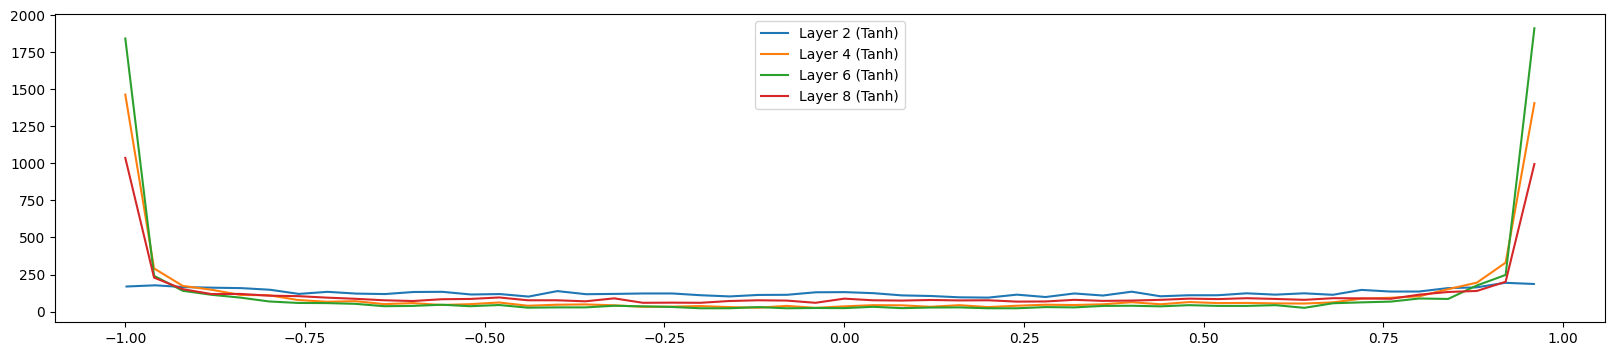

In [54]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t=layer.out
        print("Layer %d (%10s): mean %+.2f , std %.2f , saturated %.2f%%"
                % (i,
                    layer.__class__.__name__,
                    t.mean().item(),
                    t.std().item(),
                    (t > 0.97).float().mean().item() * 100))
        hy,hx=torch.histogram(t,bins=50)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.show()

In [13]:
#Training
z_train=torch.cat(C[x_train].unbind(1),1)
for layer in layers:
    z_train=layer(z_train)  
training_loss=F.cross_entropy(z_train,y_train)

# Validation
z_val=torch.cat(C[x_val].unbind(1),1)
for layer in layers:
    z_val=layer(z_val)  
validation_loss=F.cross_entropy(z_val,y_val)

#Testing
z_test=torch.cat(C[x_test].unbind(1),1)
for layer in layers:
    z_test=layer(z_test)  
testing_loss=F.cross_entropy(z_test,y_test)


print("Training Loss = ",training_loss.item())
print("Validation Loss = ",validation_loss.item())
print("Testing Loss = ",testing_loss.item())

Training Loss =  1.9478812217712402
Validation Loss =  2.058687448501587
Testing Loss =  2.058717727661133


# Loss Markdown
### Test 1
Training Loss =  1.9478812217712402 
Validation Loss =  2.058687448501587
Testing Loss =  2.058717727661133